In [32]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:

df = pd.read_csv('final_data.csv')

df.shape

# Set up  train/test split
X = df.drop(columns=['readmitted'])
y=df['readmitted']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print(f"Training set size: {len(X_train)} samples")
# print(f"Test set size: {len(X_test)} samples")
# print(f"Validaion set size: {len(X_val)} samples")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

# Step 1: Define the model as a function
def create_model(neurons = 10, optimizer='adam'):
    nn = Sequential()
    nn.add(Dense(neurons, input_dim=20, activation='relu'))
    # model.add(Dropout(dropout_rate))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return nn

# Wrap the Keras model so it can be used by scikit-learn's GridSearchCV
model = KerasClassifier(model=create_model, verbose=0)

# Step 3: Define the parameter grid
param_grid = {
    'batch_size': [10, 20, 40],
    'epochs': [10, 50, 100],
    # 'dropout_rate': [0.0, 0.1, 0.2],
    'model__neurons': [1, 5, 10]
}

# Step 4: Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Summarize the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean:.4f} (+/-{std:.4f}) with: {param}")


Training set size: 53216 samples
Test set size: 22808 samples
Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\jefel\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best: 0.8590273152464789 using {'batch_size': 40, 'epochs': 50, 'model__neurons': 5}
0.8570 (+/-0.0008) with: {'batch_size': 10, 'epochs': 10, 'model__neurons': 1}
0.8565 (+/-0.0015) with: {'batch_size': 10, 'epochs': 10, 'model__neurons': 5}
0.8576 (+/-0.0012) with: {'batch_size': 10, 'epochs': 10, 'model__neurons': 10}
0.8575 (+/-0.0019) with: {'batch_size': 10, 'epochs': 50, 'model__neurons': 1}
0.8586 (+/-0.0019) with: {'batch_size': 10, 'epochs': 50, 'model__neurons': 5}
0.8586 (+/-0.0013) with: {'batch_size': 10, 'epochs': 50, 'model__neurons': 10}
0.8564 (+/-0.0012) with: {'batch_size': 10, 'epochs': 100, 'model__neurons': 1}
0.8583 (+/-0.0015) with: {'batch_size': 10, 'epochs': 100, 'model__neurons': 5}
0.8585 (+/-0.0015) with: {'batch_size': 10, 'epochs': 100, 'model__neurons': 10}
0.8571 (+/-0.0019) with: {'batch_size': 20, 'epochs': 10, 'model__neurons': 1}
0.8574 (+/-0.0013) with: {'batch_size': 20, 'epochs': 10, 'model__neurons': 5}
0.8588 (+/-0.0027) with: {'batch_size': 

In [22]:
# test_loss,test_acc = best_model.evaluate(X_test,y_test)
# print('test accuracy:', test_acc)
best_model = grid.best_estimator_
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

Precision: 0.9869819658425892


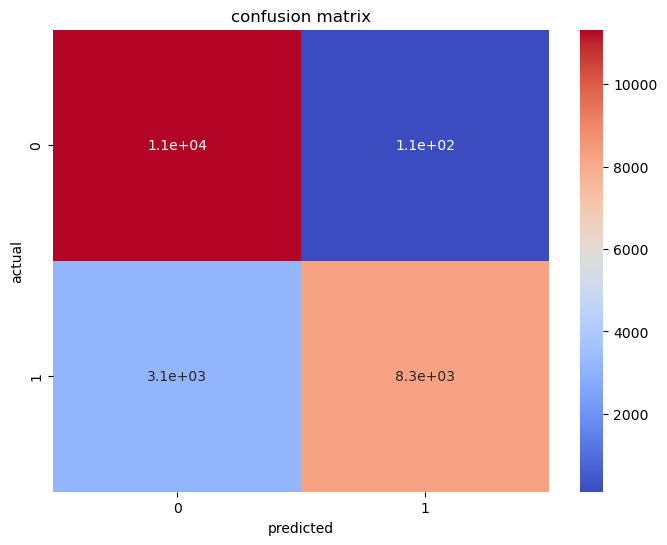

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap = 'coolwarm')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('actual')

plt.show()

# Confusion matrix shows we have no false positives (no one was predicted to be readmitted but actually never came in)
# We did have false negatives (predicted to not be readmitted but ended up being readmitted)
# For this model, we would prefer to have more false positives than false negatives. 

In [36]:
tp = cm[1,1]
tn = cm[0,0]
fp = cm[1,0]
fn = cm[0,1]

recall = tp / (tp + fn)
recall

0.9869819658425892

In [44]:
# Convert to DataFrame for easy manipulation
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.Series(y_test, name='TrueLabel')
y_pred_df = pd.Series(y_pred, name='PredictedLabel')

# Combine into one DataFrame
results = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

# Extract false positives and false negatives
false_positives = results[(results['TrueLabel'] == 0) & (results['PredictedLabel'] == 1)]
false_negatives = results[(results['TrueLabel'] == 1) & (results['PredictedLabel'] == 0)]
data_falses = pd.concat([false_positives, false_negatives])

data_falses.to_csv('data_falses.csv', index = False)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()